# `Contingent` Tutorial

In [49]:
import numpy as np
from rich import print
from contingency import Contingent
import matplotlib.pyplot as plt

np.set_printoptions(formatter={'float_kind':"{:.5g}".format})

In [2]:
y_true = np.array([0,1,0,0,1]).astype(bool)
y_pred = np.array([0,1,0,1,0]).astype(bool)

## Basic Instantiation

In [3]:
M = Contingent(y_pred = y_pred, y_true=y_true)
    
# M.precision
print(M)

Contingent(
    y_true=array([[False,  True, False, False,  True]]),
    y_pred=array([[False,  True, False,  True, False]]),
    weights=None,
    TP=array([1]),
    FP=array([1]),
    FN=array([1]),
    TN=array([2]),
    PP=array([2]),
    PN=array([3]),
    P=array([2]),
    N=array([3]),
    PPV=masked_array(data=[0.5],
             mask=[False],
       fill_value=1e+20),
    NPV=masked_array(data=[0.6666666666666666],
             mask=[False],
       fill_value=1e+20),
    TPR=masked_array(data=[0.5],
             mask=[False],
       fill_value=1e+20),
    TNR=masked_array(data=[0.6666666666666666],
             mask=[False],
       fill_value=1e+20)
)

We now have access to properties that will return useful metrics from these contingency counts, such as 

- [Matthew's Correlation Coefficient](https://en.wikipedia.org/wiki/Phi_coefficient) (MCC)
- [F1/F2](https://en.wikipedia.org/wiki/F-score) scores
- [Fowlkes-Mallows](https://en.wikipedia.org/wiki/Fowlkes%E2%80%93Mallows_index) (G) index
- Many more...

In [4]:
print(M.mcc, M.F, M.G, sep='\n')
# m = np.vstack([M.TPR,M.TNR,M.PPV,M.NPV]).T#.filled(0)
# l = np.sqrt(m).prod(axis=0)
# r = np.sqrt(1-m).prod(axis=0)
# M_batch.TPR
# np.sqrt(m)#.prod(axis=1)
# (l-r).filled(0)


[0.16667]
[0.5]
[0.5]

## Contingencies from Probabilities

Most ML systems do not output binary classifications directly, but instead output probabilities or weights. 
Thresholding these will create an entire "family" of predictions, as the threshold increases or lowers. 

`Contingent` easily handles this as a simple broadcasting operation, using the `from_scalar()` constructor: 

In [5]:
y_prob = np.array([0.1,0.8,0.1,.7,.25])

In [6]:
M_batch = Contingent.from_scalar(y_true, y_prob)
print(M_batch.weights, M_batch.y_pred, sep='\n')

M_batch.y_pred.shape

[0 1e-05 0.21429 0.85714 0.99999 1]
[[ True  True  True  True  True]
 [ True  True  True  True  True]
 [False  True False  True  True]
 [False  True False  True False]
 [False  True False False False]
 [False False False False False]]

(6, 5)

Note how the number of positives decreases as the threshold increases. 

Likewise, we can see the set of metrics is now vectorized as well: 

In [7]:
print(M_batch.mcc, M_batch.F, M_batch.G, sep='\n')

[0 0 0.66667 0.16667 0.61237 0]
[0.57143 0.57143 0.8 0.5 0.66667 0]
[0.63246 0.63246 0.8165 0.5 0.70711 0]

## Expected Values

We would like a single score that summarizes our classifier's performance accross _all_ thresholds. 

This can traditionally be done using Average Precision Score (APS), which is the average precision weighted across the _recall_ scores. 
Alternatively, `Contingent.expected` also can calculate the expected value of each provided score type, across the set of unique threshold values. 

In [8]:
for score in ('aps', 'mcc', 'F'):
    print(M_batch.expected(score))

0.8333333333333333

0.39492652768935094

0.6481253367346939

## Optional Plotting Utilities

There is an included plot utility for making nicely formatted P-R curve axes to plot your `Contingent` metrics on. 
While this does not automatically plot the P-R curves themselves, this functionality will be added at a later time. 

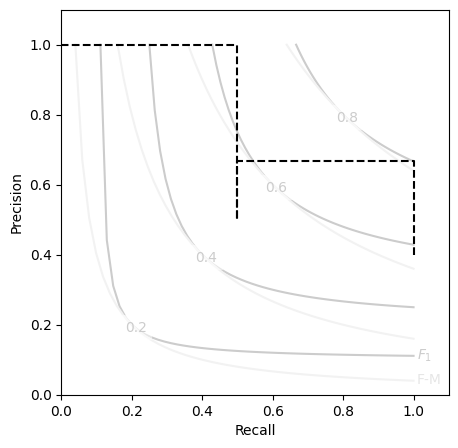

In [9]:
from contingency.plots import PR_contour

M_batch.expected('aps')
plt.figure(figsize=(5,5))
PR_contour()
plt.step(M_batch.recall, M_batch.precision, color='k', ls='--', where='post')
# plt.plot(M_batch.recall, M_batch.precision, color='k', ls='--')

## Performance

When datasets become increasingly large, the number of unique thresholds can grow significantly. 

Because looping in python is slow, we rely on boolean matrix operations to calculate the contingency counts. At the core of `Contingent.from_scalar` is a call to `numpy.less_equal.outer()`, which broadcasts the thresholding operation over all possible levels simultaneously. 

This is reasonably fast, able to calculate e.g. APS only marginally slower than the scikit-learn implementation.
In addition, the one-time cacluation of the "full" contingency set has the added benefit of amortizing the cost of subsequent metric calculations significantly. 



In [89]:
rng = np.random.default_rng(24) ## mph, the avg cruising airspeed velocity of an unladen (european) swallow
y_src = rng.random(1000)
y_true = y_src>0.7

y_pred = y_src + 0.05*rng.normal(size=1000)

In [90]:
from sklearn.metrics import average_precision_score, matthews_corrcoef
%timeit average_precision_score(y_true, y_pred)
%timeit Contingent.from_scalar(y_true, y_pred).expected('aps')

Mbig = Contingent.from_scalar(y_true, y_pred)
%timeit Mbig.expected('aps')

1.07 ms ± 231 μs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)
2.83 ms ± 55.4 μs per loop (mean ± std. dev. of 7 runs, 100 loops each)
30.3 μs ± 341 ns per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


This means that with a signle `Contingent` object, all of the various metrics can be calculated from then on, in mere microseconds. 

In addition, when scikit-learn does not have optimized aggregation functions, `Contingent` can continue on just as well. 
Say you wish to find the expected value of the MCC score over all thresholds: 

In [91]:
%timeit np.mean([matthews_corrcoef(y_true,x) for x in Mbig.y_pred])
%timeit M1000.expected('mcc')

1.36 s ± 576 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
176 μs ± 10.9 μs per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


The limit to this amortization comes from your RAM: the outer-product matrix can get huge. 
To mitigate this, `Contingent.from_scalar` has a `subsamples` option, wich allows you to approximate the threshold values with an interpolated subset, distributed according to the originals. 

With only a few subsamples, the score curves quickly converge to their "true" values. 

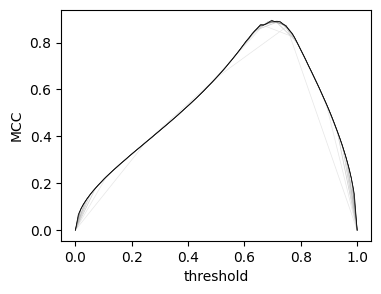

In [96]:

# rng.normal(
plt.figure(figsize=(4,3))
for subs in (5,10,15, 20, 25, 30,50,75,100): 
    plt.plot(
        np.linspace(0,1,subs),
        (Contingent.from_scalar(y_true, y_pred, subsamples=subs)).mcc,
        lw=0.5, color=f'{1-subs/100:.1f}'
    )
plt.ylabel('MCC')
plt.xlabel('threshold');

Likewise, the P-R curves: 

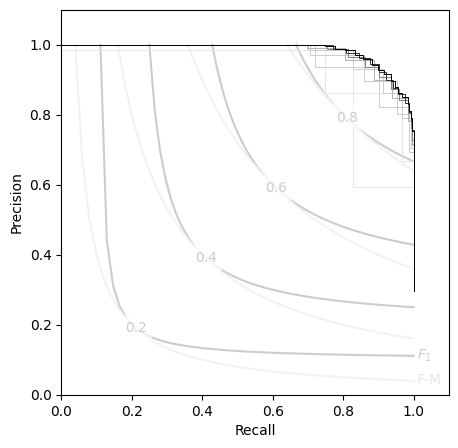

In [97]:
plt.figure(figsize=(5,5))
PR_contour()

for subs in (5,10,15, 20, 25, 30,50,75,100): 
    Msubs = Contingent.from_scalar(y_true, y_pred, subsamples=subs)
   
    plt.step(Msubs.recall, Msubs.precision, lw=0.7, color=f'{1-subs/100:.1f}', where='post')

This allows `Contingent` objects to handle some quite large data-sets:  

In [102]:
y_src = rng.random(int(1e6))
y_true = y_src>0.7

y_pred = y_src + 0.05*rng.normal(size=int(1e6))
# from sklearn.metrics import average_precision_score, matthews_corrcoef
%timeit average_precision_score(y_true, y_pred)
%timeit Contingent.from_scalar(y_true, y_pred, subsamples=200)

M200 = Contingent.from_scalar(y_true, y_pred, subsamples=200)

%timeit M200.expected('aps')


511 ms ± 21 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
678 ms ± 203 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
28 μs ± 411 ns per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


In [103]:
print(
    '{:.4g}'.format(average_precision_score(y_true, y_pred)), 
    '{:.4g}'.format(M200.expected('aps'))
)

0.9865 0.9858